In [1]:
import pandas as pd

from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
from sqlalchemy import text
import settings
import time
import numpy as np
import pickle
import json

def db_connect():
    """
    Performs database connection using database settings from settings.py.
    Returns sqlalchemy engine instance
    """
    return create_engine(URL(**settings.DATABASE))

db = db_connect()

%matplotlib inline
import matplotlib.pyplot as plt
from sqlalchemy import MetaData
import numpy as np
import pandas as pd
import csv
from collections import defaultdict
import re
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.cross_validation import train_test_split
from __future__ import division
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import seaborn as sns
from sqlalchemy import MetaData
from sqlalchemy import create_engine
from sqlalchemy.engine.url import URL
import settings
import time
import glob
import pickle

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
from sklearn import preprocessing 
import xgboost
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, accuracy_score, recall_score, precision_recall_curve, roc_curve, roc_auc_score, confusion_matrix
from sklearn.cross_validation import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV
from sklearn.feature_extraction import text 
from sklearn.base import TransformerMixin
from sklearn.naive_bayes import GaussianNB
from nltk.stem.wordnet import WordNetLemmatizer

### Test Train Split

In [16]:
provider_notes_first_24_FINAL = pd.read_pickle('../Pickles/Provider_Notes_24.p')
def remove_nums(data):
    return re.sub(r"\d+", "", data)

X = provider_notes_first_24_FINAL.text
X = X.apply(remove_nums)
y = provider_notes_first_24_FINAL.hospital_expire_flag
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

### All SAPs models

In [64]:
SAPS_ALL_df = pd.read_pickle('../Pickles/SAPS_ALL.df')

In [65]:
patient_list = pd.read_csv('../TextFiles/icustay_list.csv', header = None, names = ['icustay_id'])

In [66]:
patients_with_notes = json.load(open('../JSONs/patients_with_notes.json', 'rb'))

In [26]:
command =  '''select * from icustay_detail;'''
icustay_detail = pd.read_sql(command, db)

In [27]:
icustay_detail = icustay_detail[icustay_detail.icustay_id.isin(patient_list.icustay_id)]

In [67]:
SAPS_SHORT_df = SAPS_ALL_df[SAPS_ALL_df.icustay_id.isin(patient_list.icustay_id)]
SAPS_SHORT_df = SAPS_SHORT_df[SAPS_SHORT_df.subject_id.isin(patients_with_notes)]

In [68]:
len(SAPS_SHORT_df)

13421

#### TFIDF Log Reg

In [114]:
## Add stop words
# from nltk.corpus import stopwords
# stop = stopwords.words('english')
stopwordsfile = open('../TextFiles/stopwords.txt', 'r')
stop = []
for line in stopwordsfile:
    if len(line) > 1:
        stop.append(line.strip())
stop += ['.', ',', '(', ')', "'", '"']
# stop += map(str, range(0, 10000))

In [115]:
import pickle
tfidf_lr = pickle.load(open('../Pickles/TFIDF_LogReg.model', 'rb'))

#### TFIDF + LDA Model

In [116]:
# from sklearn.decomposition import LatentDirichletAllocation
# # for TF DTM
# lda_tf = LatentDirichletAllocation(n_topics=1, random_state=0)
# lda_tf.fit(vecs)
import pickle
LDA_lr = pickle.load(open('../Pickles/LDA_LogReg.model', 'rb'))

In [117]:
LDA_xgb = pickle.load(open('../Pickles/LDA_XGB.model', 'rb'))

### ALL MODELS

In [118]:
models = [#{'name': "GaussianNB", 'model': GaussianNB()},
          #{'name': "SVM", 'model': SVC(probability = True)}, 
          #{'name':"DecisionTree", 'model': DecisionTreeClassifier()}, 
        {'name':"SAPS All Patients", 
                             'y_test' : SAPS_ALL_df['hospital_expire_flag'], 
                             'y_proba' : SAPS_ALL_df['sapsii_prob'],
                             'y_pred': SAPS_ALL_df['sapsii'],
                             'score' : np.nan
        },                
        {'name':"SAPS > 48 Hour Stay",
                            'y_test' : SAPS_SHORT_df['hospital_expire_flag'], 
                             'y_proba' : SAPS_SHORT_df['sapsii_prob'],
                            'y_pred': SAPS_SHORT_df['sapsii'],
                             'score' : np.nan
        },
        tfidf_lr,
        LDA_lr,
        LDA_xgb
        #{'name': "TFIDF LogReg", 'model': pipe_tfidf_lr}
          #{'name':"KNearest", 'model': KNeighborsClassifier(3)},
          #{'name':"LogisticRegression", 'model': LogisticRegression(class_weight = 'balanced')}
         ]

In [119]:
for model in models:
    model['pr'] = precision_recall_curve(model['y_test'], model['y_proba'])
    model['auc'] = roc_auc_score(model['y_test'], model['y_proba'])
    model['roc'] = roc_curve(model['y_test'], model['y_proba'])
    model['accuracy'] = np.nan
    model['precision'] = np.nan
    model['recall'] = np.nan
    model['f1'] = np.nan

    
    print "For the %s model: " %model['name']
#     print "The accuracy is: %0.4f" %model['accuracy']
#     print "The precision is: %0.4f" %model['precision']
#     print "The recall is: %0.4f" %model['recall']
#     print "The f1 score is: %0.4f" %model['f1']
    print "The SCORE is: %0.4f" %model['score']
    print "The AUC is: %0.4f" %model['auc']
    print    

For the SAPS All Patients model: 
The SCORE is: nan
The AUC is: 0.8024

For the SAPS > 48 Hour Stay model: 
The SCORE is: nan
The AUC is: 0.7350

For the TFIDF LogReg model: 
The SCORE is: 0.8036
The AUC is: 0.7934

For the LDA LogReg model: 
The SCORE is: 0.7986
The AUC is: 0.7593

For the LDA XGBoost model: 
The SCORE is: 0.8105
The AUC is: 0.7818



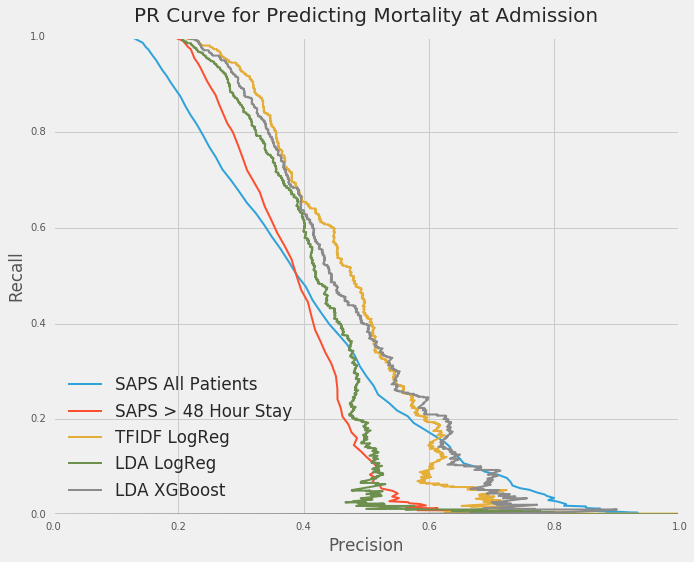

In [135]:
f, ax = plt.subplots(1, 1, figsize = (10, 8))
ttl = ax.set_title('PR Curve for Predicting Mortality at Admission', fontsize = 20)
ttl.set_position([.5, 1.02])
ax.set_xlabel('Precision')
ax.set_ylabel('Recall')
#f.subplots_adjust(hspace=.5)
for model in models:
    ax.plot(model['pr'][0],model['pr'][1], linewidth = 2, label = model['name'])

plt.legend(loc = 3, fontsize = 'large')
    

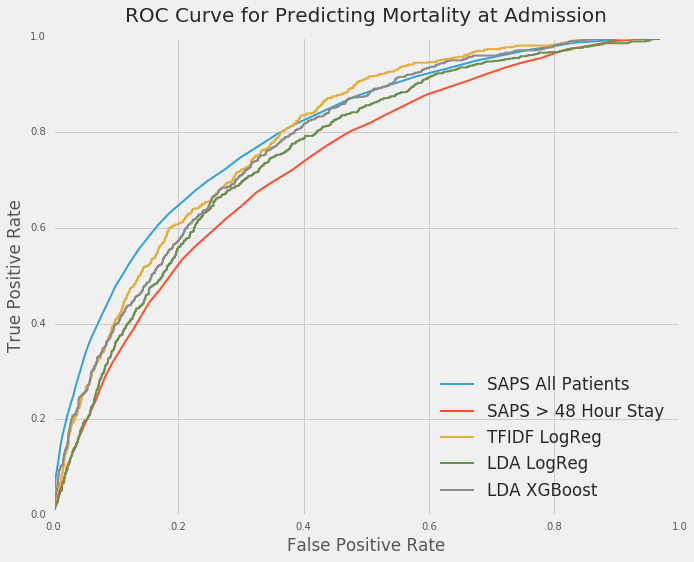

In [136]:
plt.style.use('fivethirtyeight')

f, ax = plt.subplots(1, 1, figsize = (10, 8))
ttl = ax.set_title('ROC Curve for Predicting Mortality at Admission', fontsize = 20)
ttl.set_position([.5, 1.02])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
#f.subplots_adjust(hspace=.5)
for model in models:
    ax.plot(model['roc'][0],model['roc'][1], linewidth = 2, label = model['name'])

plt.legend(loc = 4, fontsize = 'large')
    

In [125]:
plt.figure(figsize = (6, 6))
lr_coefs = models[2]['coef_imp'][::-1]
names, coefs = zip(*lr_coefs)
# death

In [126]:
lr_coefs_pos = [x for x in lr_coefs if x[1] > 0][-25:]
lr_coefs_neg = [x for x in lr_coefs if x[1] < 0][-25:]

In [127]:
lr_coefs_neg

[(u'sheath', -1.0235162069784942),
 (u'pain management', -1.0287189213892314),
 (u'plan wean', -1.0345888920824005),
 (u'asthma', -1.034613447948185),
 (u'sedated propofol', -1.1016963922694727),
 (u'headache', -1.1111087212646398),
 (u'ciwa', -1.2174560186523504),
 (u'nsr ectopy', -1.2261445659864476),
 (u'pleasant', -1.243999473181127),
 (u'oob', -1.2607128786958139),
 (u'vss', -1.2738976536955724),
 (u'strength', -1.2740355497282729),
 (u'insulin gtt', -1.2744995370157599),
 (u'strong', -1.2924121105420114),
 (u'cta', -1.2963199167871642),
 (u'cooperative', -1.3311764432414475),
 (u'diet', -1.394027351240144),
 (u'dilaudid', -1.4453320885177192),
 (u'neck', -1.5067838855569744),
 (u'nausea', -1.5105360932223222),
 (u'protocol', -1.589764037886811),
 (u'extubate', -1.6802873599529269),
 (u'extubation', -2.0342806600965315),
 (u'cpap', -2.0699398937418985),
 (u'extubated', -2.349830714374411)]

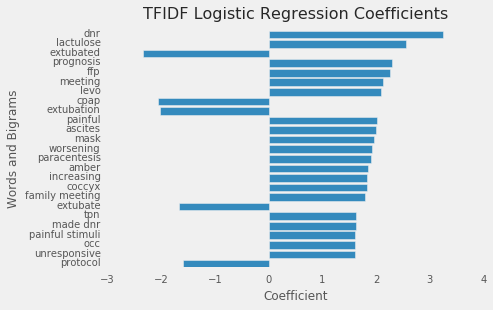

In [143]:
#plt.title("TFIDF Logistic Regression Coefficients")
plt.barh(range(0, 25), coefs[-25:])
plt.yticks(np.arange(0.5, 25.5), names[-25:])
plt.grid(False)
ax = plt.gca()
ttl = ax.set_title("TFIDF Logistic Regression Coefficients", fontsize = 16)
ax.set_xlabel("Coefficient", fontsize = 12)
ax.set_ylabel("Words and Bigrams", fontsize = 12)
ttl.set_position([.5, 1.02])
# ax.set_axis_bgcolor('white')
print

### Visualize Mortality by Topic

In [2]:
lda = pickle.load(open('../Pickles/Gensim_LDA_1.p', 'rb'))

In [3]:
dictionary = pickle.load(open('../Pickles/dictionary.p', 'rb'))

In [4]:
corpus = pickle.load(open('../Pickles/corpus.p', 'rb'))

In [ ]:
lda_corpus = lda[corpus]

In [15]:
X[0]

NameError: name 'X' is not defined

In [14]:
dictionary[76]

u'dnr'

In [6]:
lda_docs = [doc for doc in lda_corpus]

In [7]:
lda_docs = [dict(x) for x in lda_docs]

In [8]:
lda_df = pd.DataFrame(lda_docs)

In [10]:
lda_df.shape

(13421, 50)

In [19]:
corpus[0]
dictionary[131]

u'fib'

In [21]:
X[0]
# y[0]

u"MICU NSG PROG NOTE: days\nRemains stable on high dose neo, tapering levofed, awake, episode VT today, DNR, afebrile, on alot of abx, beginning to make urine.\n\nROS:\n\nCARDIAC: Maintaining map> on neo and levofed. He has tolerated steady wean of levofed through day. beat run VT, self limiting. Cardiology is involved and discussing keeping lido gtt or changing to amiodarone. Keeping close monitoring of lytes.... replaced calcium this afternoon. Labs pnd. Continuing to cycle ck's and troponin. Echo today-> ef %. Bolusing w/ cc ns and following FICK CO minutes post fluid.\n\nRESP: good abg. good oxygenation. Strong cough. Has alot of thick tan secretions, requiring frequent suctioning.\n\nRENAL; elevated bun/cr this am. Has begun to make urine. (cc/hr most of day). UA pnd. REplaced foley. For c&s.\n\nGI: npo\n\nFLuid/electrolyte: approx L pos for day. On maintenance ivf w/ prn boluses. Swan in place and functioning well. Wedges w/ approx /cc air (w/out difficulty) and has a good wave f

In [174]:
lda_df['y'] = y

In [175]:
lda_df.columns

Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
         12,   13,   14,   15,   16,   17,   18,   19,   20,   21,   22,   23,
         24,   25,   26,   27,   28,   29,   30,   31,   32,   33,   34,   35,
         36,   37,   38,   39,   40,   41,   42,   43,   44,   45,   46,   47,
         48,   49, u'y'],
      dtype='object')

In [275]:
# pickle.dump(lda_df, open('../Pickles/LDA_topics.df', 'wb'))

In [295]:
grouped_lda = lda_df.groupby(by = 'y', axis = 0)

In [296]:
grouped_lda = grouped_lda.mean().reset_index()

In [301]:
# grouped_lda.drop('y', axis = 1, inplace = True)
# grouped_lda.iloc[0]


y     0.000000
0     0.079807
1     0.044642
2     0.031020
3     0.061790
4     0.056390
5     0.017927
6     0.024951
7     0.219416
8     0.132011
9     0.177057
10    0.043204
11    0.048605
12    0.019587
13    0.040975
14    0.056949
15    0.098540
16    0.040635
17    0.089479
18    0.026469
19    0.129612
20    0.201296
21    0.022360
22    0.021368
23    0.022993
24    0.045758
25    0.022241
26    0.071378
27    0.078594
28    0.058502
29    0.020130
30    0.115881
31    0.020780
32    0.024088
33    0.070431
34    0.183505
35    0.109221
36    0.041557
37    0.027655
38    0.031848
39    0.061590
40    0.040994
41    0.045665
42    0.018328
43    0.037240
44    0.084602
45    0.056273
46    0.182221
47    0.154176
48    0.232826
49    0.019484
Name: 0, dtype: float64

In [287]:
percent_lda_df =grouped_lda.copy()

In [302]:
percent_lda_df = percent_lda_df.div(percent_lda_df.sum(axis=1), axis=0)

In [303]:
# percent_lda_df.iloc[0] = percent_lda_df.iloc[0]/(percent_lda_df.iloc[0] + percent_lda_df.iloc[1])
# percent_lda_df.iloc[1] = 1 - percent_lda_df.iloc[0]

In [314]:
diffs = zip(percent_lda_df.columns, abs(percent_lda_df.iloc[1] - percent_lda_df.iloc[0]))

In [ ]:
diffs = sorted(diffs, key = lambda x: x[1], reverse = True)
cols, differences = zip(*diffs)
cols = list(cols)

In [322]:
diffs

[(48, 0.017446699744385206),
 (39, 0.0084965195051986703),
 (35, 0.0077518945296840419),
 (7, 0.0076503782839907365),
 (43, 0.0074913350997781909),
 (19, 0.0066970317953861484),
 (25, 0.00563530276488532),
 (34, 0.0050267780683205809),
 (8, 0.0049871173237994899),
 (46, 0.004787982809353216),
 (10, 0.0046011483294129164),
 (40, 0.0039573062217365777),
 (27, 0.0039151644499251757),
 (15, 0.003827286780757836),
 (5, 0.0037808035977733752),
 (26, 0.0036918789667022209),
 (22, 0.0034449088007598126),
 (44, 0.0033905967844166211),
 (36, 0.0033803851522668585),
 (1, 0.00329468137253109),
 (11, 0.0028438772250729584),
 (24, 0.0028311676209460471),
 (17, 0.0024919233372365929),
 (42, 0.0024032888777736107),
 (20, 0.0022446188257569735),
 (23, 0.0021822139523133104),
 (49, 0.0021193187546751265),
 (6, 0.0020560715864035815),
 (0, 0.0019504707532989329),
 (45, 0.0018312606705241374),
 (14, 0.0015736881793446574),
 (33, 0.0014993828529172443),
 (21, 0.0013585730548597852),
 (32, 0.001154052833739

In [324]:
cols

[48,
 39,
 35,
 7,
 43,
 19,
 25,
 34,
 8,
 46,
 10,
 40,
 27,
 15,
 5,
 26,
 22,
 44,
 36,
 1,
 11,
 24,
 17,
 42,
 20,
 23,
 49,
 6,
 0,
 45,
 14,
 33,
 21,
 32,
 13,
 37,
 12,
 29,
 47,
 16,
 30,
 38,
 4,
 31,
 18,
 28,
 9,
 41,
 3,
 2]

In [ ]:
percent_lda_df = percent_lda_df[cols]

In [325]:
percent_lda_df

,48,39,35,7,43,19,25,34,8,46,...,30,38,4,31,18,28,9,41,3,2
0,0.028349,0.024066,0.023710,0.023661,0.016415,0.023205,0.022697,0.022406,0.017613,0.017709,...,0.020377,0.020361,0.019682,0.020289,0.020288,0.019730,0.019739,0.019804,0.019812,0.019898
1,0.010903,0.015570,0.015958,0.016011,0.023906,0.016508,0.017062,0.017379,0.022600,0.022497,...,0.019589,0.019606,0.020347,0.019685,0.019686,0.020295,0.020284,0.020213,0.020204,0.020111


#### Before Percentages

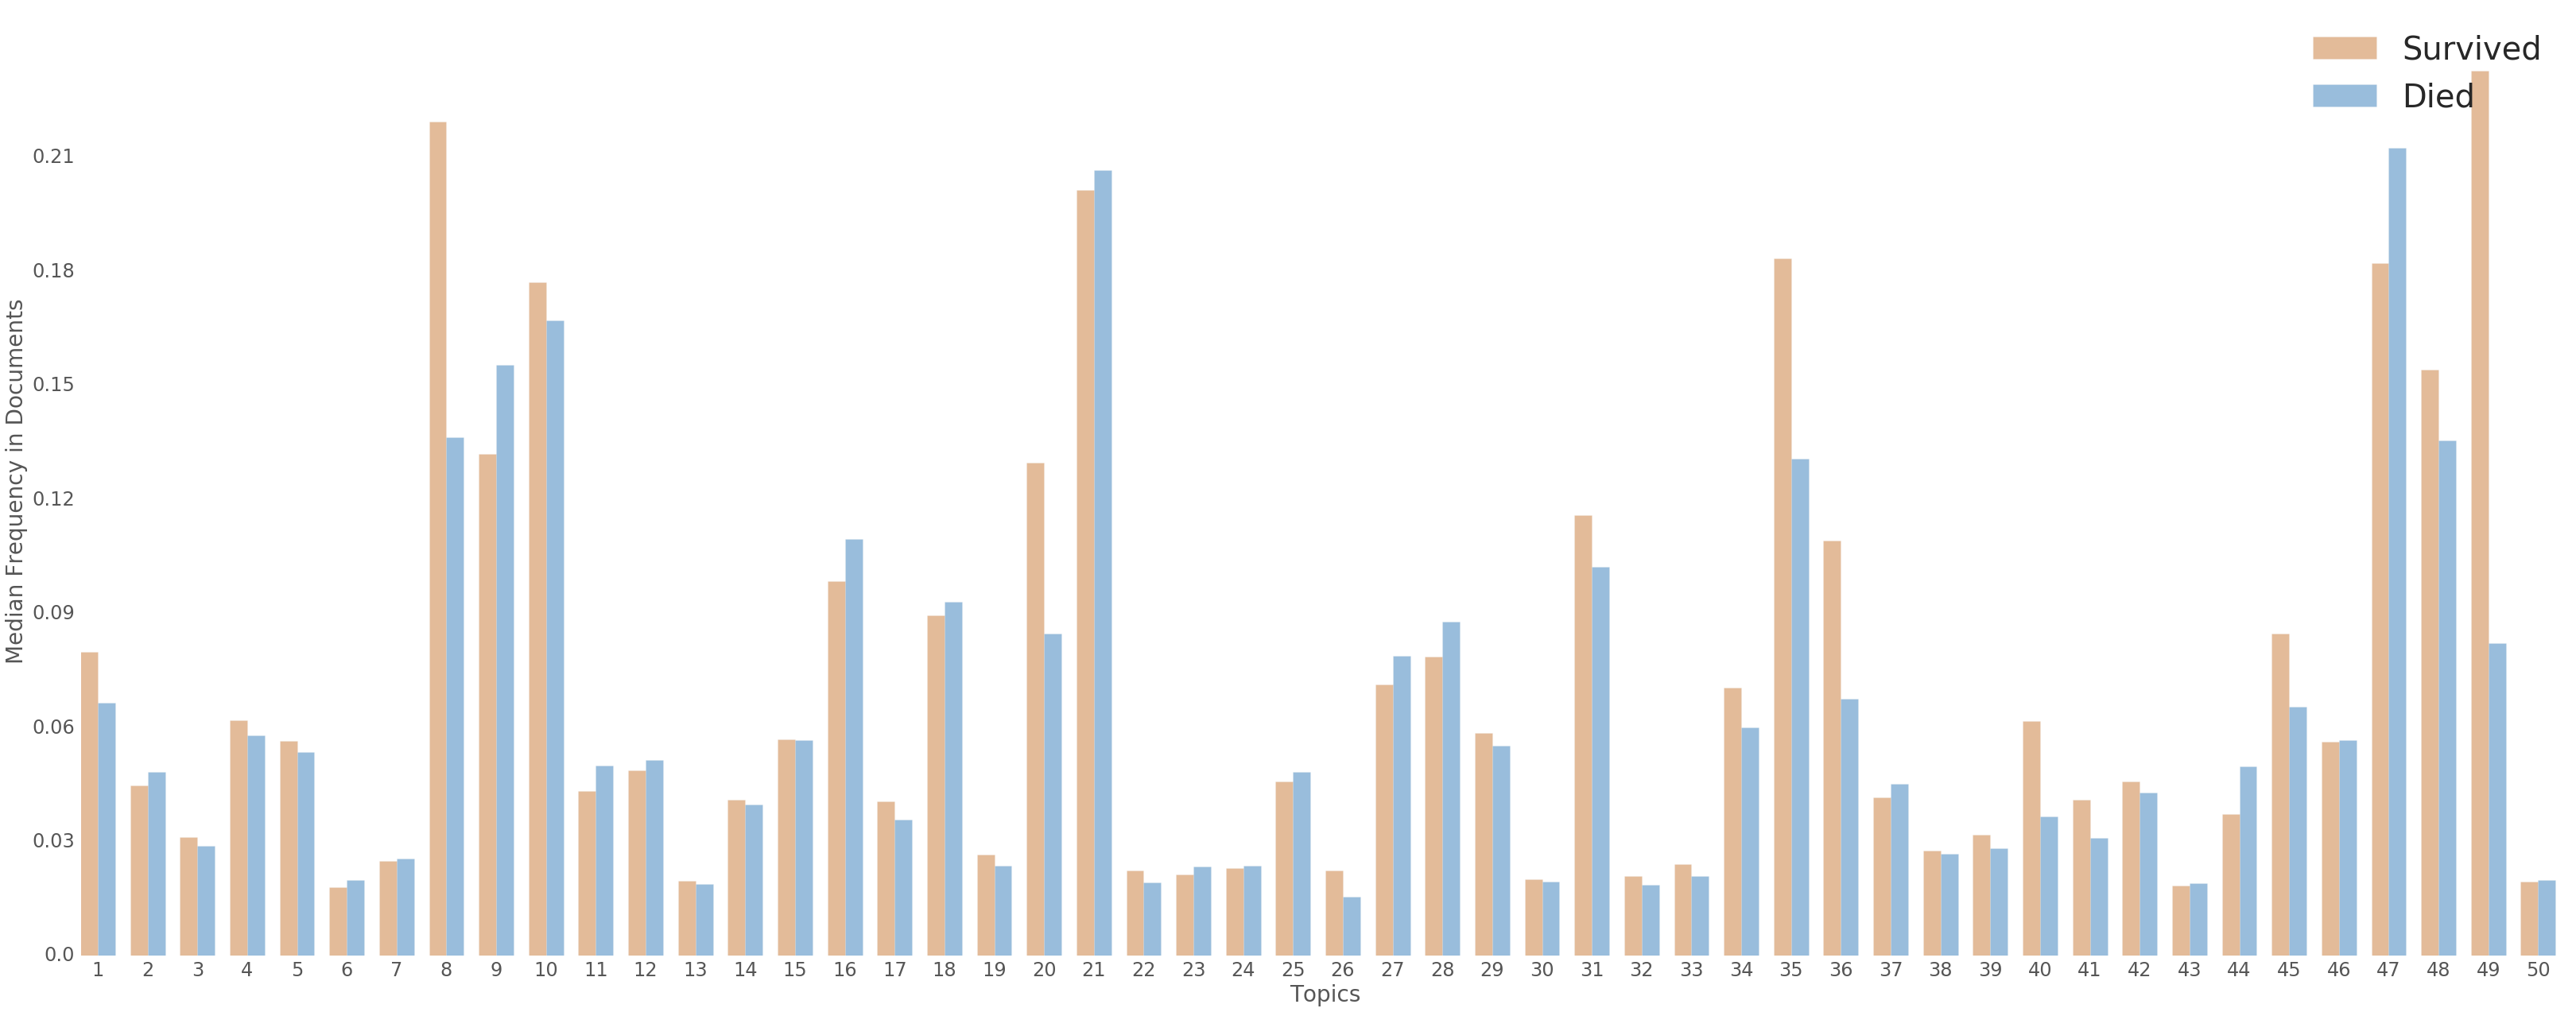

In [290]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(50,20))
index = grouped_lda.columns
width = 0.35
opacity = 0.4
rect0 = ax.bar(index, grouped_lda.iloc[0], width, alpha = 0.4, color = '#bb5600', label = 'Survived')
rect1 = ax.bar(index + width, grouped_lda.iloc[1], width, alpha = 0.4, color = '#005ba8', label = 'Died')

ax.set_xlabel('Topics', fontsize = 28)
# ax.set_title('Median Frequency in Documents', fontsize = 26, name='Helvetica')
ax.set_xticks(index + width)
ax.set_xticklabels(range(1,51), fontsize = 24)
ax.set_yticks(np.arange(0,0.24, 0.03))
ax.set_yticklabels(np.arange(0,0.24, 0.03), fontsize = 24)
ax.set_ylabel('Median Frequency in Documents', fontsize = 28)


# ax.grid(False)

# def autolabel(rects):
#     # attach some text labels
#     for rect in rects:
#         width = rect.get_width()
#         ax.text(rect.get_y() + rect.get_height()/2., 1.05*width,
#                 '%d' % int(width),
#                 ha='center', va='bottom')

# autolabel(rect0)
# autolabel(rect1)
plt.legend(loc = 1, fontsize = 40)
ax.set_axis_bgcolor('white')
print

#### After percentages

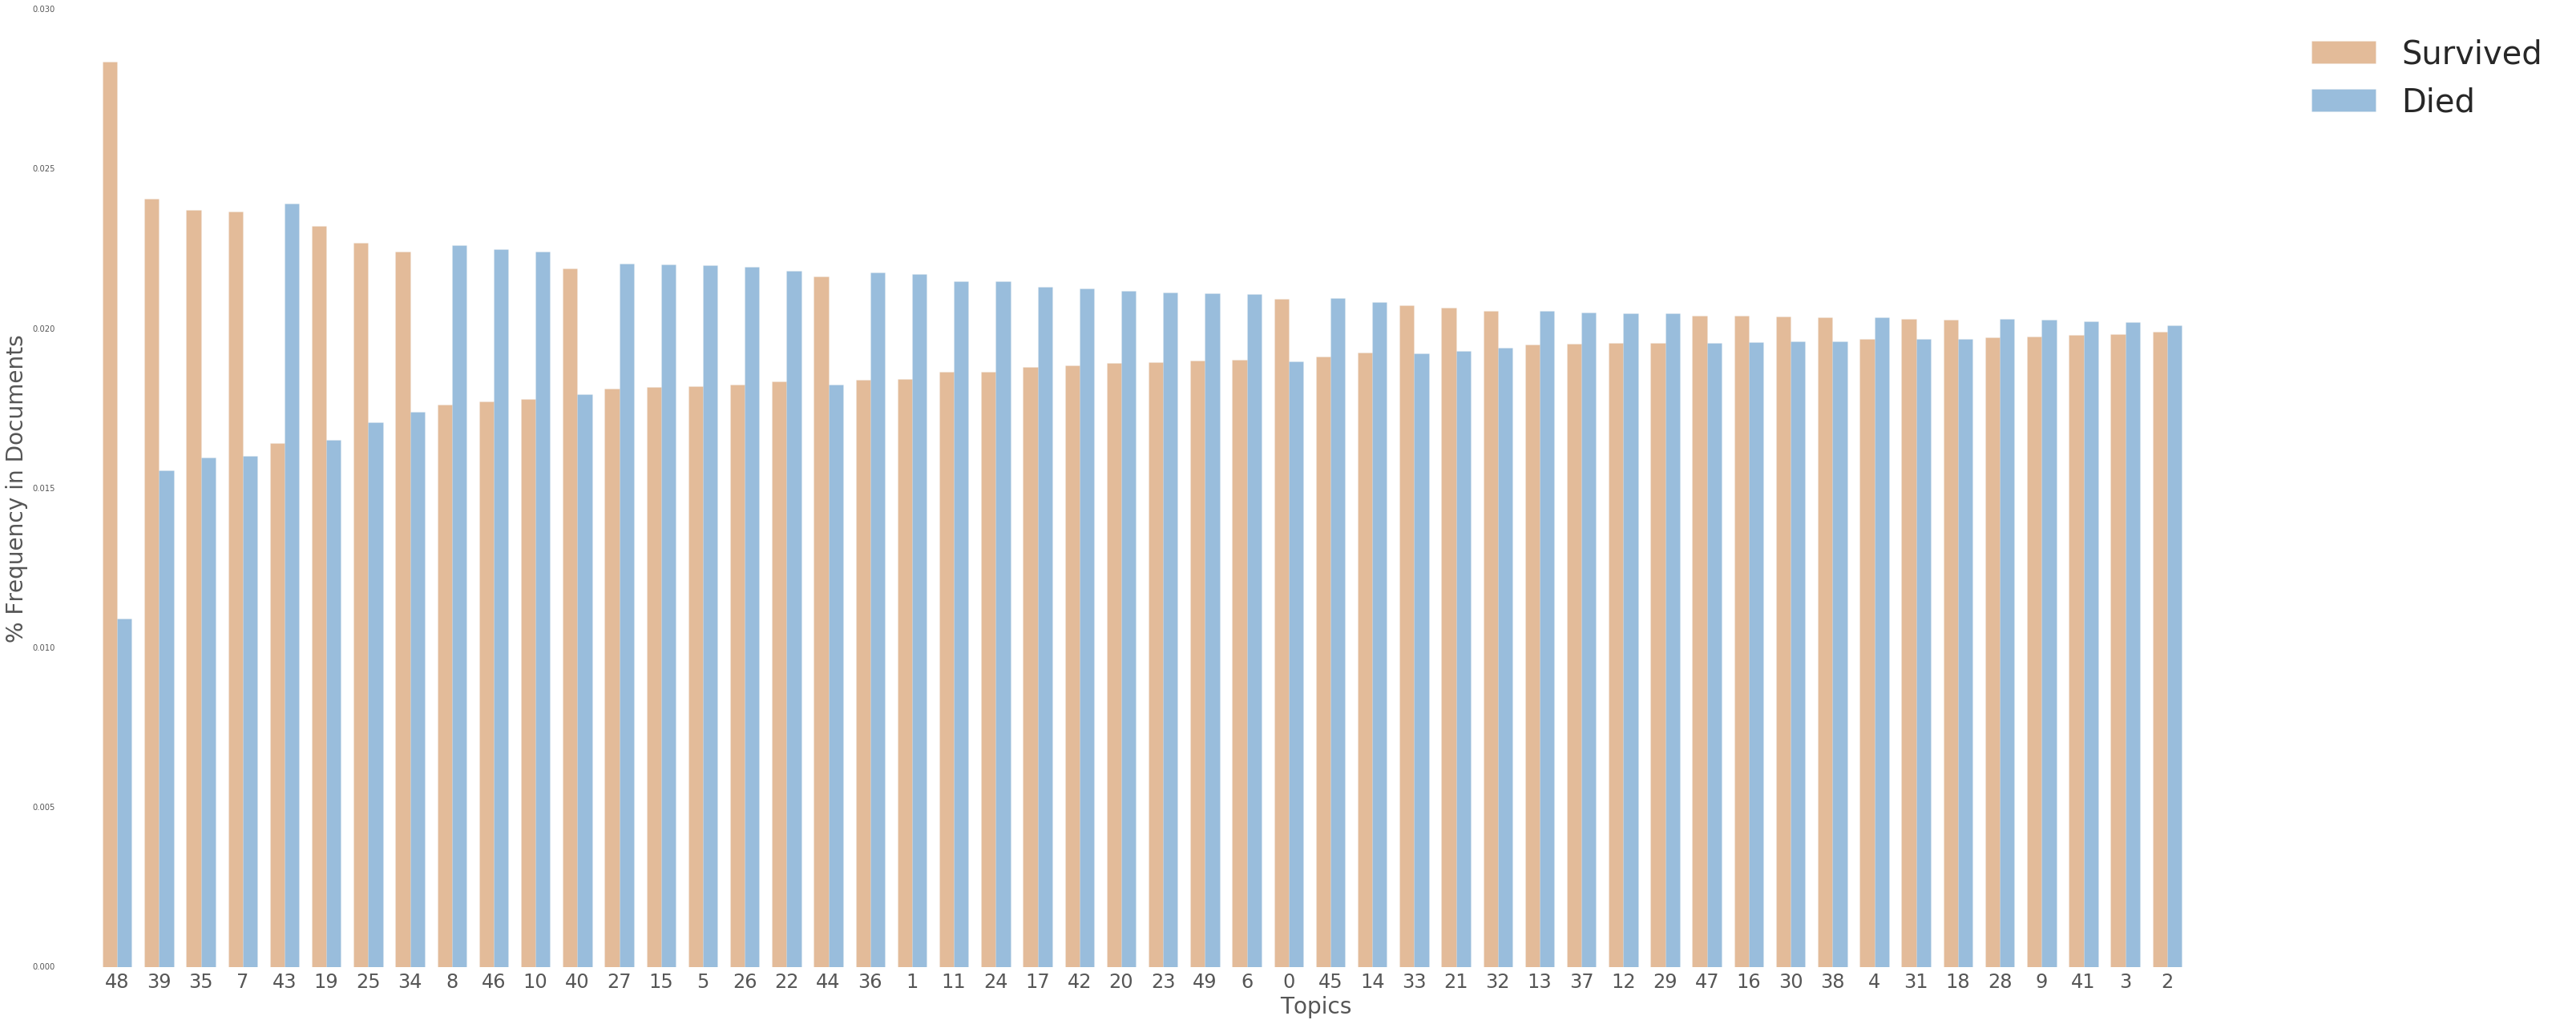

In [333]:
plt.style.use('ggplot')

fig, ax = plt.subplots(figsize=(50,20))
index = percent_lda_df.columns
width = 0.35
opacity = 0.4
rect0 = ax.bar(range(1,51), percent_lda_df.iloc[0], width, alpha = 0.4, color = '#bb5600', label = 'Survived')
rect1 = ax.bar(np.arange(1+width,51+width), percent_lda_df.iloc[1], width, alpha = 0.4, color = '#005ba8', label = 'Died')

ax.set_xlabel('Topics', fontsize = 28)
# ax.set_title('Median Frequency in Documents', fontsize = 26, name='Helvetica')
ax.set_xticks(np.arange(1 + width,51 + width))
ax.set_xticklabels(index, fontsize = 24)
# ax.set_yticks(np.arange(0,0.24, 0.03))
# ax.set_yticklabels(np.arange(0,0.24, 0.03), fontsize = 24)
ax.set_ylabel('% Frequency in Documents', fontsize = 28)


# ax.grid(False)

# def autolabel(rects):
#     # attach some text labels
#     for rect in rects:
#         width = rect.get_width()
#         ax.text(rect.get_y() + rect.get_height()/2., 1.05*width,
#                 '%d' % int(width),
#                 ha='center', va='bottom')

# autolabel(rect0)
# autolabel(rect1)
plt.legend(loc = 1, fontsize = 40)
ax.set_axis_bgcolor('white')
print

In [258]:
lda.print_topic( num_words = 10)

[(0,
  u'0.027*surgery + 0.022*abdominal + 0.015*ngt + 0.015*lap + 0.013*surgical + 0.012*drain + 0.012*incision + 0.011*sicu + 0.009*resection + 0.009*dressing'),
 (1,
  u'0.033*esrd + 0.030*foot + 0.030*dialysis + 0.022*vascular + 0.021*pvd + 0.018*stage + 0.014*cad + 0.013*end + 0.012*bacteremia + 0.012*chronic'),
 (2,
  u'0.050*speaking + 0.032*daughter + 0.017*english + 0.015*interpreter + 0.013*spanish + 0.013*language + 0.011*russian + 0.011*tpa + 0.010*speaks + 0.009*clot'),
 (3,
  u'0.026*confused + 0.025*agitated + 0.022*agitation + 0.018*confusion + 0.017*haldol + 0.016*mental + 0.014*dementia + 0.014*restraints + 0.012*ativan + 0.012*delirium'),
 (4,
  u'0.024*fibrillation + 0.023*coumadin + 0.015*atrial + 0.014*valve + 0.014*ventricular + 0.014*systolic + 0.013*chf + 0.012*mitral + 0.012*aortic + 0.011*action'),
 (5,
  u'0.065*succ + 0.061*nac + 0.040*hourly + 0.034*impairment + 0.030*contd + 0.030*lit + 0.028*mesh + 0.026*mushrooms + 0.026*lady + 0.020*visualization'),
 (